# Malaria Exploratory Data Analysis
Malaria is one of the worlds leading causes of death. In this notebook, I look at the overall numbers of Malaria and the trend in estimated cases across different regions between the years 2000 and 2017, focusing on the African continent. I then look at how the number of cases compares with weather conditions, Malaria funding and distributed  Insecticide Treated Nets (ITNs). Data was collected from multiple sources:

World Health Organisation (WHO) (Malaria Cases https://apps.who.int/gho/data/node.main.A1362?lang=en)  
                                (Funding and ITNs https://www.who.int/publications/i/item/9789241565721)  
World Weather Online  (Weather Conditions www.worldweatheronline.com accessed with API key)  
Berkeley Earth (Global Temperatures http://berkeleyearth.org/archive/data/)  
Global Fund (Funding and ITNs https://data.theglobalfund.org)  
World Bank (Population and Exchange Rates https://data.worldbank.org/)

First, we read in the necessary packages.

In [2]:
import pandas as pd
import math

Here I read in the data from WHO, stored as csv files.

In [3]:
#read in csv files
est_cases_master = pd.read_csv('Data/WHO/cases/malaria_estimated_cases.csv', skiprows=1)
inc_cases =  pd.read_csv('Data/WHO/cases/malaria_case_incidence_per_1000_pop_at_risk.csv', skiprows=1)
countries_WHO_region = pd.read_csv('Data/countries.csv')
#reorder columns
cols = est_cases_master.columns.tolist()
cols = cols[::-1]
cols = cols[-1:] + cols[:-1]
est_cases_master = est_cases_master[cols]
cols_inc = inc_cases.columns.tolist()
cols_inc = cols_inc[::-1]
cols_inc = cols_inc[-1:] + cols_inc[:-1]
inc_cases = inc_cases[cols_inc]

In [3]:
est_cases_master.head()

,Country,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,353 343 [181 000 - 581 000],454 823 [210 000 - 746 000],278 223 [134 000 - 472 000],213 914 [118 000 - 352 000],284 198 [189 000 - 409 000],369 809 [247 000 - 524 000],614 491 [439 000 - 838 000],630 308 [495 000 - 801 000]
1,Algeria,1,1,55,8,0,0,0,0
2,Angola,3 125 901 [2 009 000 - 4 595 000],3 040 461 [1 910 000 - 4 456 000],3 111 760 [1 964 000 - 4 531 000],3 384 997 [2 191 000 - 4 970 000],3 768 087 [2 485 000 - 5 526 000],4 303 582 [2 882 000 - 6 212 000],4 485 050 [3 010 000 - 6 468 000],4 615 605 [3 106 000 - 6 661 000]
3,Argentina,14,0,0,0,0,0,0,0
4,Armenia,0,0,0,0,0,0,0,0


In [4]:
inc_cases.head()

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,95.54,91.89,104.01,68.41,37.64,27.08,20.53,21.55,17.84,14.77,15.11,18.87,11.15,9.01,12.67,14.91,26.11,27.07,29.01
1,Algeria,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00
2,Angola,324.44,328.28,312.30,315.35,319.66,323.69,313.81,286.72,241.19,204.35,185.52,175.99,174.43,180.90,187.94,199.99,219.99,228.91,228.91
3,Argentina,2.39,1.15,0.66,0.64,0.60,1.30,1.08,1.95,0.65,0.42,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Armenia,0.05,0.03,0.02,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [5]:
#check which countries are mislabelled and are not in study
#Naming discrepancies between WHO Malaria data and WHO country list definitions
#Comoros needed to be added to list of countries
countries_study=est_cases_master['Country'].tolist()
countries_WHO = countries_WHO_region['Country'].tolist()
for country_study in countries_study:
    if country_study not in countries_WHO:
        print('Mislabelled: {}'.format(country_study))
        for country_WHO in countries_WHO:
            if (country_study[-3:] or country_study[:3]) in country_WHO:
                print('''Could be this name {}
                '''.format(country_WHO))

#No. of countries not inluded in study = 86
#No. of countries in study = 107
#Together 193 official UN member states. 2 countries are non-member observer states:
#the Holy See and the State of Palestine

In [6]:
#assigning WHO Region to each country
country_region=[]
for country in countries_study:
    country_df = countries_WHO_region.loc[countries_WHO_region['Country']==country]
    region_name = country_df.values.tolist()[0][0]
    country_region.append(region_name)
est_cases_master.insert(1,'WHO_Region',country_region,True)

In [7]:
#Creating separate df for median, min, max
est_cases = est_cases_master.copy()    
est_cases_min = est_cases_master.copy()
est_cases_max = est_cases_master.copy()
est_cases_key_list = est_cases.columns.values.tolist()
est_cases_key_list = est_cases_key_list[2:]
for key in est_cases_key_list:
    est_cases_minmax_list=[]
    for num in est_cases_min[key].values:
        if '[' in num:
            est_cases_minmax_list.append(num)
        else:
            est_cases_minmax_list.append('nan')
    est_cases_min[key] = est_cases_minmax_list
    est_cases_max[key] = est_cases_minmax_list
for key in est_cases_key_list:
    est_cases[key] = [num.split('[')[0].replace(' ','') for num in est_cases[key].values]
    est_cases_min[key] = [num.split('[')[-1].split('-')[0].replace(' ','') for num in est_cases_min[key].values]
    est_cases_max[key] = [num.split('-')[-1].replace(']','').replace(' ','') for num in est_cases_max[key].values]
for key in est_cases_key_list:
    est_cases[key] = [int(num) for num in est_cases[key].values]
    est_cases_min[key] = [float(num) for num in est_cases_min[key].values]
    est_cases_max[key] = [float(num) for num in est_cases_max[key].values]

In [8]:
# Summing estimated cases
WHO_region = est_cases.groupby('WHO_Region').sum().reset_index() 
# Pivot df
WHO_region_pivot = WHO_region.melt(id_vars='WHO_Region',
                                   var_name='Year',
                                   value_name='Cases')
WHO_region_pivot = WHO_region_pivot.pivot(
        columns='WHO_Region',
        index='Year',
        values='Cases').reset_index()

In [10]:
#adding WHO region to each country for incidence rate
countries_study_inc=inc_cases['Country'].tolist()
inc_country_region=[]
for country in countries_study_inc:
    inc_country_region.append(countries_WHO_region[countries_WHO_region['Country']==country].values.tolist()[0][0])
years_list_inc = [str(num) for num in range(2000,2019)]
inc_cases.insert(1,'WHO_Region',inc_country_region,True)
#finding the mean for each WHO region
inc_cases_region = inc_cases.groupby('WHO_Region').mean().reset_index()
inc_cases_region_ = pd.melt(inc_cases_region, id_vars=['WHO_Region'], value_vars=years_list_inc,
                        var_name='Year', value_name='Inc_Cases')

In [11]:
#Plotting estimated incidence of Malaria 
fig7 = px.line(inc_cases_region_, x='Year', y='Inc_Cases', color='WHO_Region',
               title='Estimated Incidence of Malaria Cases per 1000 people at risk',
               labels={'Inc_Cases':'Estimated Cases (Number/1000 people at risk)'})
fig7.write_image('Figures/line/Inc_Malaria_WHORegion.jpg')

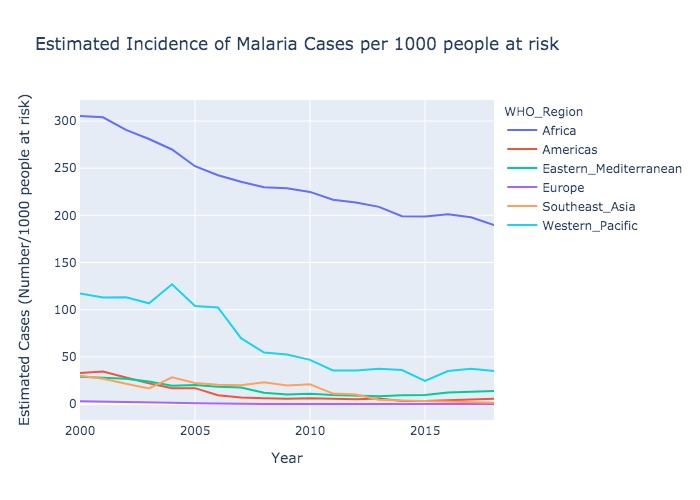

In [12]:
#African Union Defined Regions
AU_Dict={
        'SA':['Angola','Botswana','Eswatini','Malawi','Mozambique',
              'Namibia','South Africa','Zambia','Zimbabwe'],

        'EA':['Comoros','Djibouti','Eritrea','Ethiopia','Kenya','Madagascar',
              'Mauritius','Rwanda','Seychelles','Somalia','South Sudan','Sudan',
              'United Republic of Tanzania','Uganda'],

        'CA':['Burundi','Cameroon','Central African Republic','Chad',
              'Congo','Democratic Republic of Congo',
              'Equatorial Guinea','Gabon','Sao Tome and Principe'],

        'NA':['Algeria','Egypt','Libyan Arab Jamahiriya','Morocco','Tunisia'],

        'WA':['Benin','Burkina Faso','Cape Verde','Côte d\'Ivoire',
              'Gambia','Ghana','Guinea','Guinea-Bissau','Liberia',
              'Mali','Niger','Nigeria','Senegal','Sierra Leone','Togo','Mauritania']
        }

#Cross checking WHO and AU naming system
#rename mislabelled countries
for region,countries in AU_Dict.items():
    for country in countries:
        if country not in countries_WHO:     
            print('**Mislabelled: {}'.format(country))
            for name in countries_WHO:
                #print(country, name)
                if (country[-3:] or country[:3]) in name:
                    print('Could be this name {}'.format(name))

AU_country_list=[]
for region,countries in AU_Dict.items():
    for country in countries:
        AU_country_list.append(country)
#select African (AU defined) countries from WHO data
inc_cases_africa = inc_cases[inc_cases['Country'].isin(AU_country_list)].reset_index(drop=True)
inc_cases_africa = inc_cases_africa.drop('WHO_Region',axis=1)
inc_cases_africa_countrylist = inc_cases_africa['Country'].tolist()
#Assiging AU region to each African country
inc_cases_africa_regionlist=[]
for country in inc_cases_africa_countrylist:
    for region,countries in AU_Dict.items():
        if country in countries:
            inc_cases_africa_regionlist.append(region)            
inc_cases_africa.insert(1,'AU_Region',inc_cases_africa_regionlist,True)

In [13]:
# Plotting incidence rate of Malaria
inc_AU_region = inc_cases_africa.groupby('AU_Region').mean().reset_index()
inc_AU_region = pd.melt(inc_AU_region, id_vars=['AU_Region'], value_vars=years_list_inc,
                        var_name='Year', value_name='Inc_Cases')
fig8 = px.line(inc_AU_region, x='Year', y='Inc_Cases',
               title='Incidence of Malaria by African Subregion', color='AU_Region',
               labels={'Inc_Cases':'Malaria Cases (Number/1000 people at risk)'})
fig8.write_image('Figures/line/Inc_Malaria_AURegion.jpg')

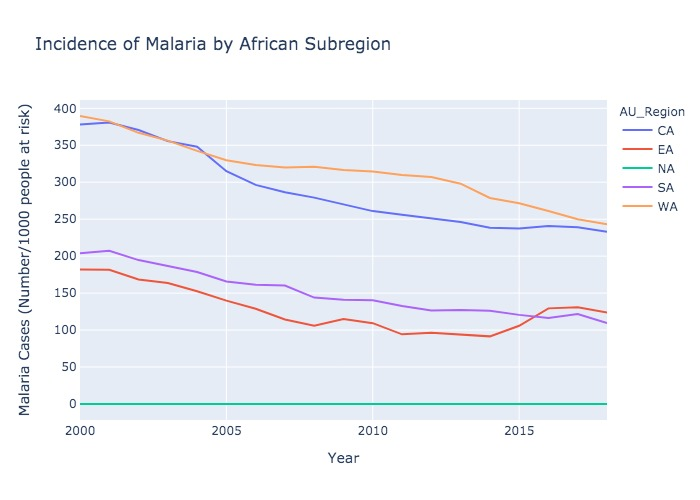

In [15]:
#Plotting cases by selected African region (Plotly)
Africa_REGIONS_name=['SA','EA','CA','NA','WA']
for name in Africa_REGIONS_name:
    inc_cases_africa_select = inc_cases_africa[inc_cases_africa['AU_Region']==name]
    inc_cases_africa_select = pd.melt(inc_cases_africa_select, id_vars=['Country'], value_vars=years_list_inc,
                                      var_name='Year', value_name='Inc_Cases')
    fig13 = px.line(inc_cases_africa_select, x='Year', y='Inc_Cases', color='Country',
                    title='Incidence rate of Malaria in Selected Region ({})'.format(name),
                    range_y=[0,600], labels={'Inc_Cases':'Incidence of Malaria Cases (Number/1000 people at risk)'})
    fig13.write_image('Figures/line/Selected_Region_{}.jpg'.format(name))

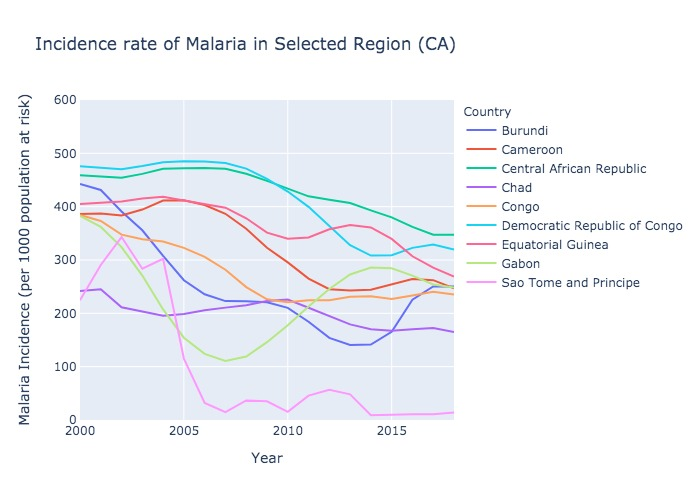

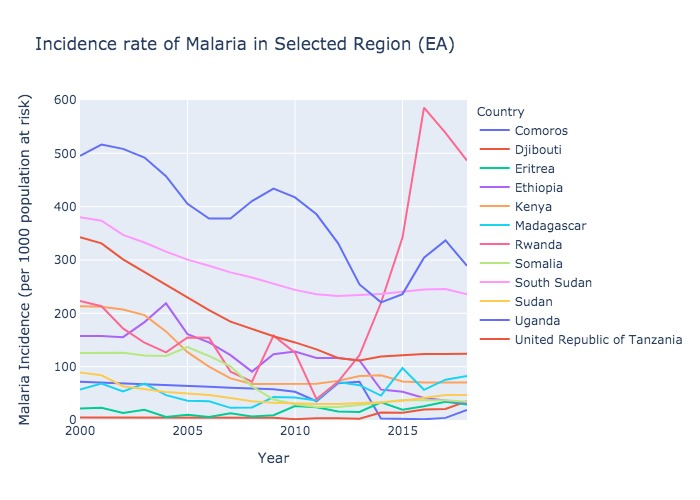

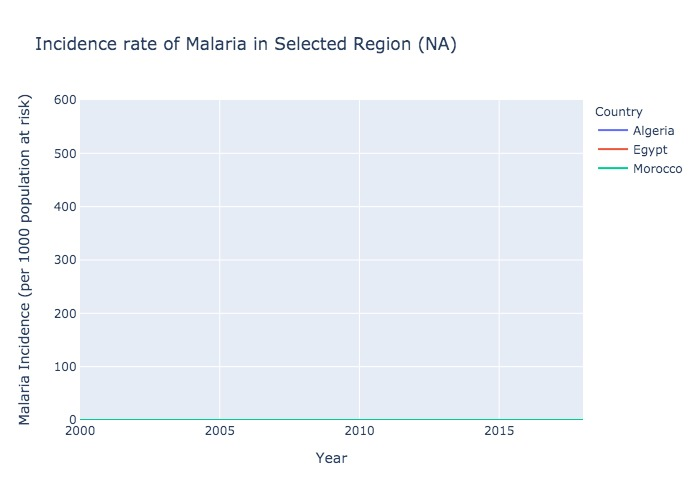

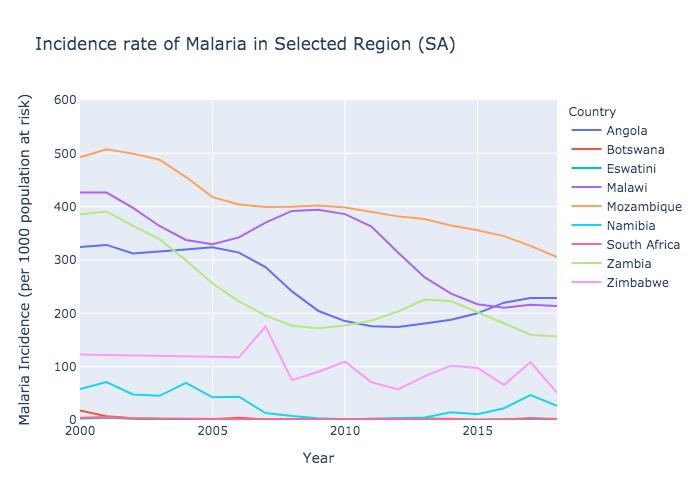

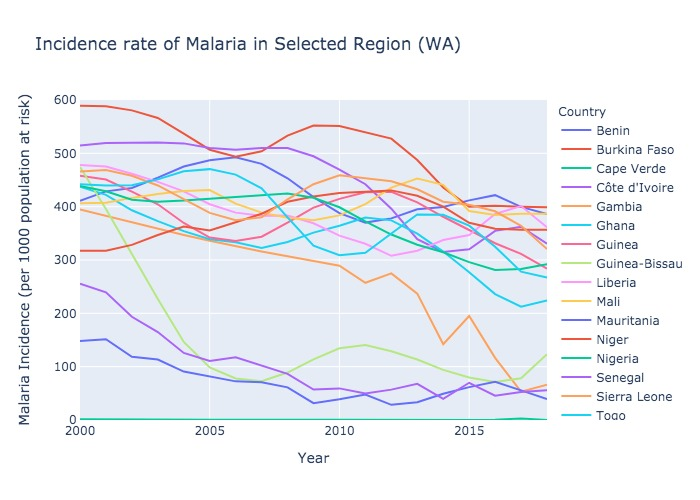

In [19]:
#Plotting estimated cases in African countries 
est_cases_african_countries = est_cases[est_cases['WHO_Region']=='Africa'].reset_index(drop=True)
est_cases_african_countries['est_cases_max_2017'] = est_cases_max[est_cases_max['WHO_Region']=='Africa']['2017'].reset_index(drop=True) - est_cases_african_countries['2017']
est_cases_african_countries['est_cases_min_2017'] = est_cases_african_countries['2017'] - est_cases_min[est_cases_min['WHO_Region']=='Africa']['2017'].reset_index(drop=True)
est_cases_african_countries = est_cases_african_countries.sort_values('2017').reset_index(drop=True)
#split df in half due to label handling
est_cases_african_countries_df1 = est_cases_african_countries.iloc[:22, :] 
est_cases_african_countries_df2 = est_cases_african_countries.iloc[22:, :].reset_index(drop=True)
count=0
for df in [est_cases_african_countries_df1, est_cases_african_countries_df2]:
    fig14 = px.bar(df, x='2017', y='Country',
                  title='Estimated Cases of Malaria in Africa in 2017', orientation='h',
                  error_x_minus='est_cases_min_2017',
                  error_x='est_cases_max_2017',
                  range_x=[0,80000000],
                  labels={'2017':'Estimated Malaria Cases',
                          'Country':''
                          })
    fig14.update_traces(error_x_color='blue',error_x_thickness=1)
    fig14.write_image('Figures/bar/EstimatedCases_Africa_half{}.jpg'.format(count))
    count+=1

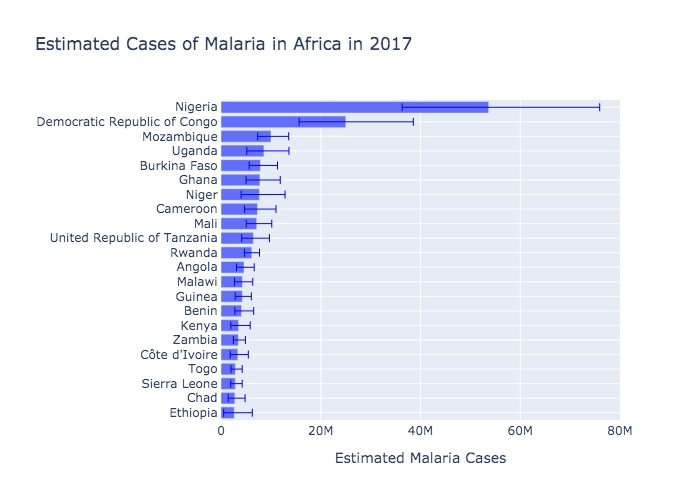

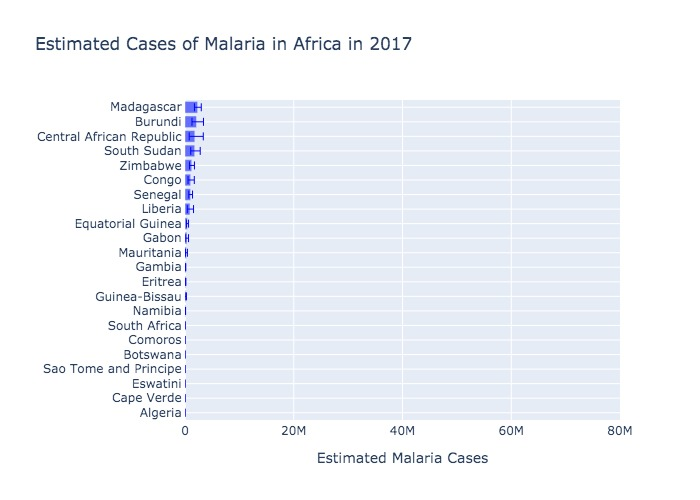

In [20]:
#Countries with highest percentage of worldwide cases
total_cases = est_cases['2017'].sum()
est_cases['2017_Perc'] = (est_cases['2017']/total_cases)*100
est_cases_top5=est_cases[est_cases['2017_Perc']>3.8].sort_values('2017_Perc')
fig5 = px.bar(est_cases_top5, x='2017_Perc', y='Country',
              title='Highest Share of Estimated Malaria Cases',
              labels={'2017_Perc':'Percentage of Worldwide Cases (%)',
                      'Country':''
                      })
fig5.write_image('Figures/bar/Highest_Malaria_Cases.jpg')
est_cases = est_cases.drop('2017_Perc',axis=1)

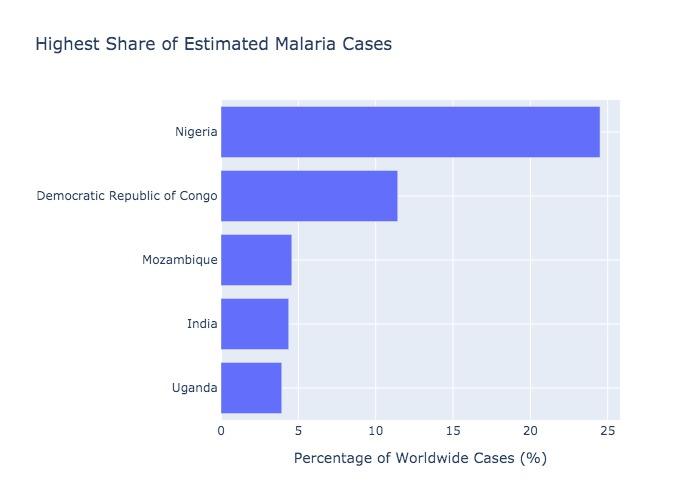

In [21]:
#Incidence rate for African countries
inc_cases_africa=inc_cases_africa.sort_values('2018').reset_index(drop=True)
fig3 = px.bar(inc_cases_africa, x='2018', y='Country', title='Estimated Incidence of Malaria Cases in Africa in 2018',
              color = 'AU_Region', color_discrete_sequence=px.colors.qualitative.Bold,
              orientation='h',
              width=500,
              height=1500,
              labels={
                      '2018':'Incidene of Malaria Cases (Number/1000 people at risk)',
                      'Country':'',
                      'AU_Region':'African Union Region'
                      })
fig3.update_layout(yaxis_categoryorder = 'total ascending')

AU_Dict={'NA':'Northern Afica','WA':'Western Africa','SA':'Southern Africa',
         'CA':'Central Africa','EA':'Eastern Africa'}
for trace in fig3.data:
    for key,value in AU_Dict.items():
        if trace.name == key:
            trace.name=value
            break
fig3.write_image('Figures/bar/Inc_Malaria_AfricanCountries.jpg')

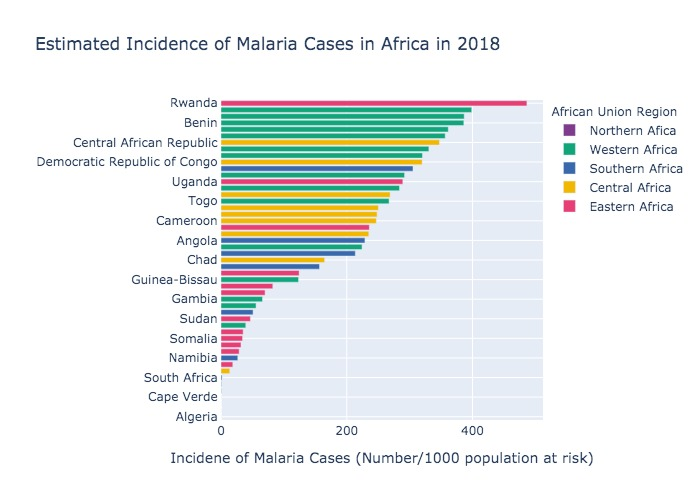